In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [3]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

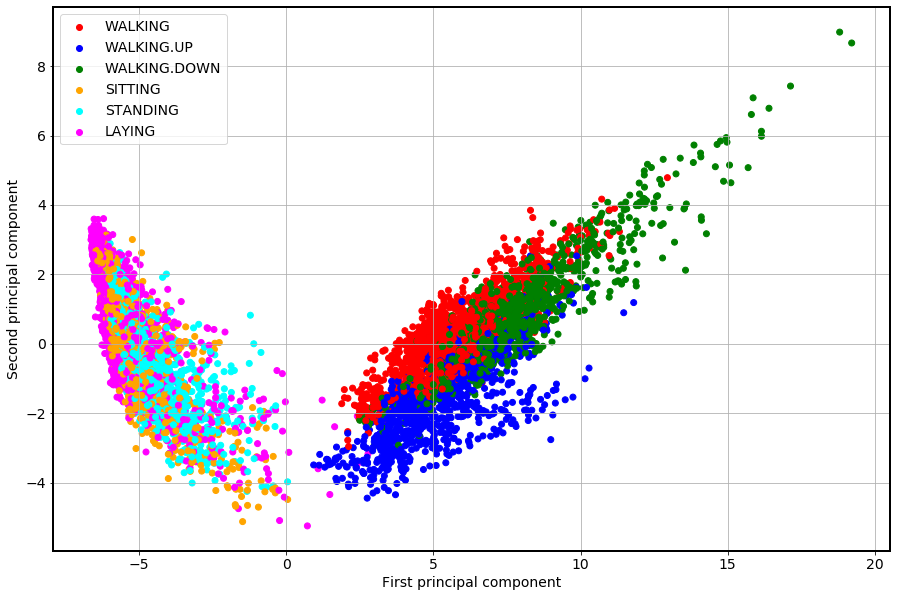

In [4]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [5]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [125]:
F_ssa_L5 = SSA(X_train[1000].reshape(9,128)[0][:20], 10)

In [126]:
F_ssa_L5.Sigma

array([1.6377292e+00, 1.5188354e+00, 1.3378077e+00, 1.1773354e+00,
       1.0288353e+00, 1.0095402e+00, 9.2279035e-01, 9.1341490e-01,
       8.8453919e-01, 1.1185817e-03], dtype=float32)

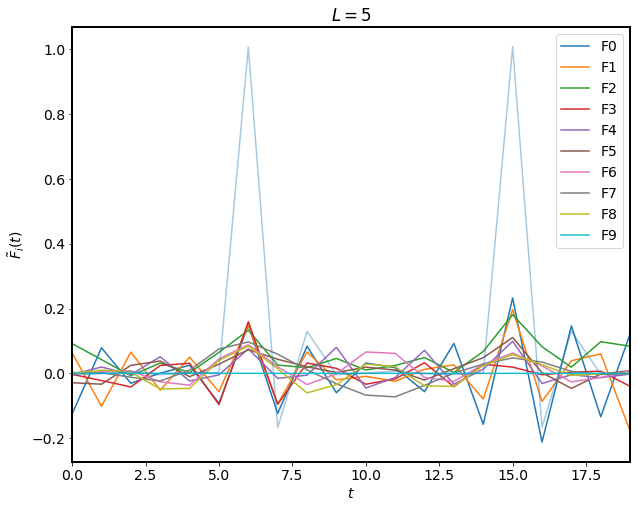

In [127]:
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$");
plt.show()

In [10]:
F_ssa_L5.Sigma

array([4.5140433, 4.006917 , 3.9541388, 3.4382558, 3.3234324],
      dtype=float32)

In [11]:
F_ssa_L5.TS_comps.shape

(128, 5)

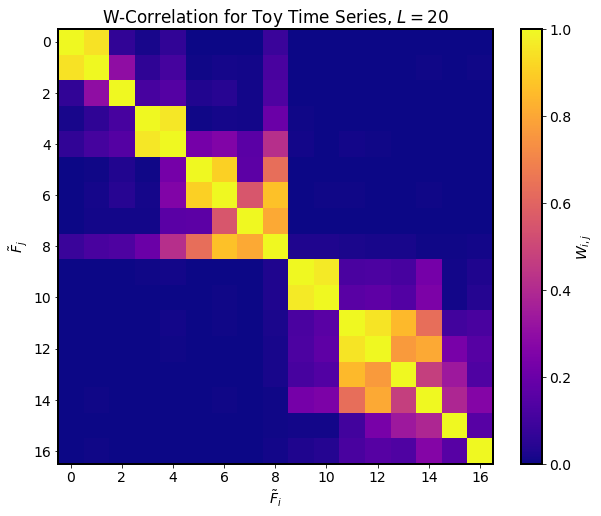

In [136]:
F_ssa_L20 = SSA(X_train[0].reshape(9,128)[0], 17)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$");

In [317]:
series = {}
for i in range(17):
    for j in range(17):
        if F_ssa_L20.Wcorr[i][j] > 0.3 and i < j:
            if i in series:
                series[i].append(j)
            else:
                series[i] = [j]
                series[i].append(i)
slices = [value for value in series.values()]
slices

[[1, 0],
 [4, 3],
 [8, 4],
 [6, 5, 8],
 [7, 6, 8],
 [8, 7],
 [10, 9],
 [12, 11, 13, 14],
 [13, 12, 14],
 [14, 13, 15],
 [15, 14]]

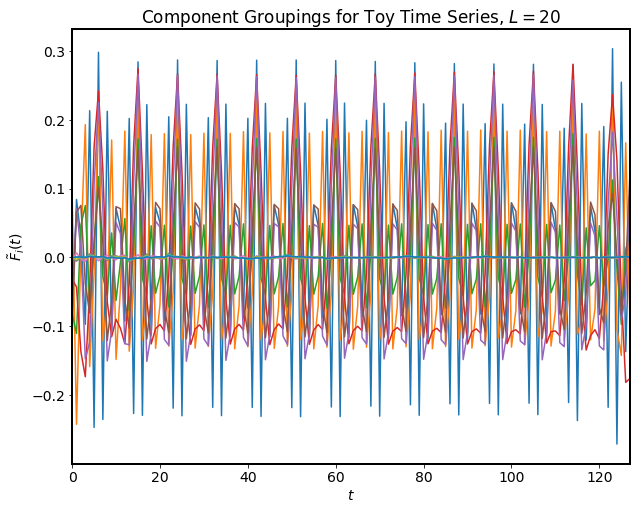

In [318]:
for s in slices:
    F_ssa_L20.reconstruct(s).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");

In [326]:
F_ssa_L20.reconstruct([8, 4]).to_numpy().shape

(128,)

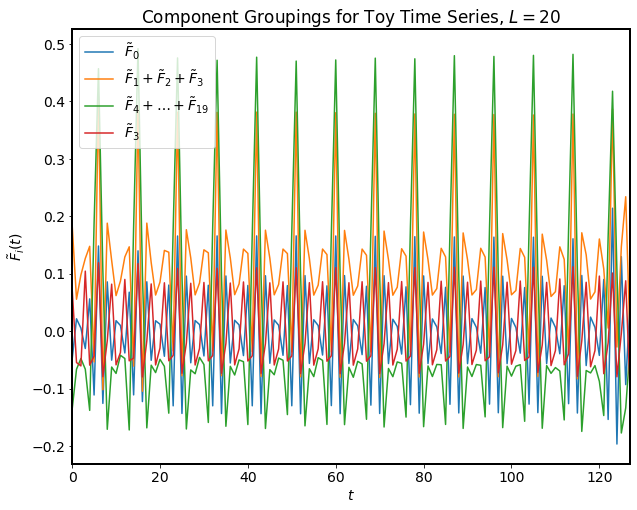

In [13]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

In [267]:
%%time
X_train_new = []
for x in X_train:
    x = x.reshape(9, 128)
    a = []
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        a.append(F_ssa_L10.Sigma)
    X_train_new.append(a)
X_train_new = np.array(X_train_new)

CPU times: user 730 ms, sys: 98.2 ms, total: 828 ms
Wall time: 210 ms


In [53]:
%%time
X_test_new = []
for x in X_test:
    x = x.reshape(9, 128)
    a = []
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        a.append(F_ssa_L10.Sigma)
    X_test_new.append(a)
X_test_new = np.array(X_test_new)

CPU times: user 34min, sys: 3min 58s, total: 37min 59s
Wall time: 9min 34s


In [438]:
%%time
X_train_new = np.array([])
for x in X_train:
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L5 = SSA(t, 5)
        series = {}
        for i in range(5):
            for j in range(5):
                if F_ssa_L5.Wcorr[i][j] > 0.3 and i < j:
                    if i in series:
                        series[i].append(j)
                    else:
                        series[i] = [j]
                        series[i].append(i)
        slices = [value for value in series.values()]
        for s in slices:
            if len(a) != 0:
                a = np.append(a, F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128), axis=0)
            else:
                a = F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128)
    if len(X_train_new) != 0:
        X_train_new = np.append(X_train_new, a[:14].reshape(1,14,128), axis=0)
    else:
        X_train_new = a[:14].reshape(1,14,128)

CPU times: user 42min 38s, sys: 7min 44s, total: 50min 23s
Wall time: 12min 41s


In [442]:
%%time
X_test_new = np.array([])
for x in X_test:
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L5 = SSA(t, 5)
        series = {}
        for i in range(5):
            for j in range(5):
                if F_ssa_L5.Wcorr[i][j] > 0.3 and i < j:
                    if i in series:
                        series[i].append(j)
                    else:
                        series[i] = [j]
                        series[i].append(i)
        slices = [value for value in series.values()]
        for s in slices:
            if len(a) != 0:
                a = np.append(a, F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128), axis=0)
            else:
                a = F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128)
    if len(X_test_new) != 0:
        X_test_new = np.append(X_test_new, a[:14].reshape(1,14,128), axis=0)
    else:
        X_test_new = a[:14].reshape(1,14,128)

CPU times: user 13min 20s, sys: 1min 56s, total: 15min 16s
Wall time: 3min 50s


In [443]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
from keras.utils import np_utils

In [444]:
X_train_new = X_train_new.reshape(X_train_new.shape[0], -1)
X_train_new = X_train_new.astype('float32')
X_train_new /= np.amax(X_train_new)
y_train_new = y_train.reshape(-1)
y_train_new = np_utils.to_categorical(y_train, 6)

In [445]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.9)

In [446]:
model.fit(X_train_new, y_train_new, epochs=100, validation_split=0.1, batch_size=16, shuffle=True,
          callbacks=[reduce_lr])

Train on 6616 samples, validate on 736 samples
Epoch 1/100
6616/6616 [==============================] - 2s 273us/step - loss: 1.0526 - accuracy: 0.5426 - val_loss: 0.8207 - val_accuracy: 0.6562
Epoch 2/100
6616/6616 [==============================] - 1s 190us/step - loss: 0.7143 - accuracy: 0.7062 - val_loss: 0.6927 - val_accuracy: 0.7622
Epoch 3/100
6616/6616 [==============================] - 1s 192us/step - loss: 0.5931 - accuracy: 0.7476 - val_loss: 0.6777 - val_accuracy: 0.7568
Epoch 4/100
6616/6616 [==============================] - 1s 191us/step - loss: 0.5375 - accuracy: 0.7879 - val_loss: 0.6483 - val_accuracy: 0.7826
Epoch 5/100
6616/6616 [==============================] - 1s 190us/step - loss: 0.4594 - accuracy: 0.8253 - val_loss: 0.5256 - val_accuracy: 0.8247
Epoch 6/100
6616/6616 [==============================] - 1s 190us/step - loss: 0.4132 - accuracy: 0.8495 - val_loss: 0.4762 - val_accuracy: 0.8492
Epoch 7/100
6616/6616 [==============================] - 1s 189us/step 

In [447]:
X_test_new = X_test_new.reshape(X_test_new.shape[0], -1)
X_test_new = X_test_new.astype('float32')
X_test_new /= np.amax(X_test_new)

In [448]:
predictions= model.predict(X_test_new)

In [449]:
y_pred = [np.argmax(x) for x in predictions]
y_test = y_test.reshape(-1)
(y_pred == y_test).mean()

0.8652867322701052

In [450]:
from sklearn.metrics import classification_report

In [451]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       496
           1       0.81      0.90      0.85       471
           2       0.85      0.89      0.87       420
           3       0.81      0.79      0.80       491
           4       0.86      0.80      0.83       532
           5       0.96      1.00      0.98       537

    accuracy                           0.87      2947
   macro avg       0.86      0.87      0.86      2947
weighted avg       0.87      0.87      0.86      2947

